In [41]:
filepaths = {
    "SplitGP(Ours)":"results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_2.70.csv",

    "Personalized models via FL":"results/splitgp_vgg11_results_CIFAR10_method_personalized_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/personalized.csv",
     "Multi-exit NN via FL/SL":"results/splitgp_vgg11_results_CIFAR10_method_multi-exit_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.0_ETH_0.2/multi-exit_combined_results_eth_3.00_gamma_0.5_lambda_split_0.0.csv",

    "Generalized global model via FL/SL":"results/splitgp_vgg11_results_CIFAR10_method_multi-exit_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.0_ETH_0.2/multi-exit_combined_results_eth_3.00_gamma_0.5_lambda_split_0.0.csv",


}

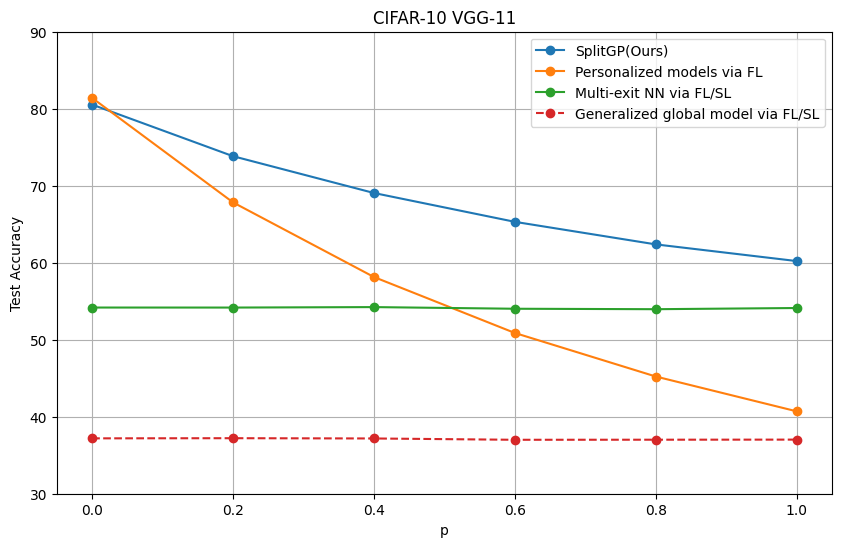

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for method, path in filepaths.items():
    df = pd.read_csv(path)
    # print(list(df))
    # print(df.head())
    # Only plot if both columns exist
    if 'p' in df.columns and 'selective_acc' in df.columns:
        if method == "Generalized global model via FL/SL":
            plt.plot(df['p'], df['full_acc']*100, marker='o', linestyle='--', label=method)
        else:
            plt.plot(df['p'], df['selective_acc']*100, marker='o', linestyle='-', label=method)

plt.xlabel('p')
plt.ylabel('Test Accuracy')
plt.ylim(30, 90)
plt.title('CIFAR-10 VGG-11')
plt.grid(True)
plt.legend()
plt.show()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
plt.figure(figsize=(10,6))
filepaths = glob.glob("results/splitgp_cnn_results_MNIST_method_splitgp_rounds_120_clients_1_gamma_0.5_lambda_split_0.2_ETH_0.05/*.csv")
filepaths

['results/splitgp_cnn_results_MNIST_method_splitgp_rounds_120_clients_1_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_0.80_gamma_0.5_lambda_split_0.2.csv',
 'results/splitgp_cnn_results_MNIST_method_splitgp_rounds_120_clients_1_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_gamma_eth_sweep_combined.csv',
 'results/splitgp_cnn_results_MNIST_method_splitgp_rounds_120_clients_1_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_0.20_gamma_0.5_lambda_split_0.2.csv',
 'results/splitgp_cnn_results_MNIST_method_splitgp_rounds_120_clients_1_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_2.80_gamma_0.5_lambda_split_0.2.csv',
 'results/splitgp_cnn_results_MNIST_method_splitgp_rounds_120_clients_1_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_3.00_gamma_0.5_lambda_split_0.2.csv',
 'results/splitgp_cnn_results_MNIST_method_splitgp_rounds_120_clients_1_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_1.20_gamma_0.5_l

<Figure size 1000x600 with 0 Axes>

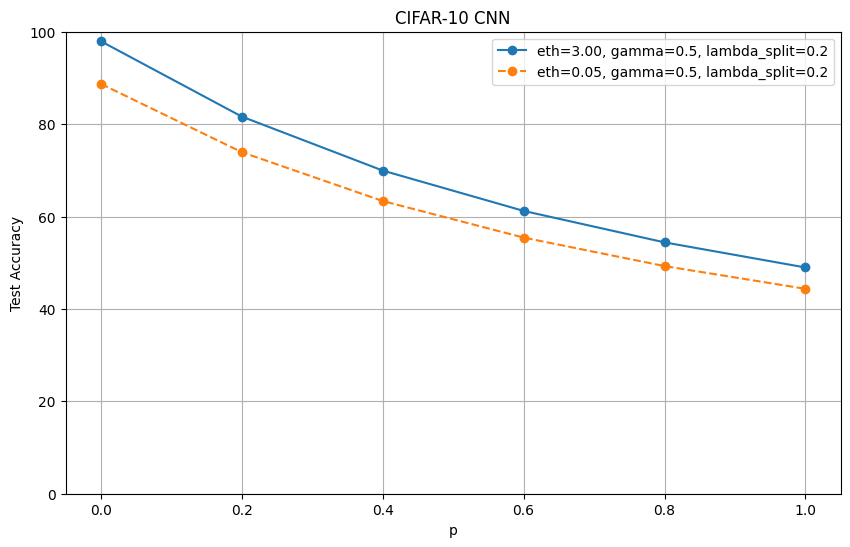

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re

plt.figure(figsize=(10,6))
filepaths = glob.glob('results/splitgp_cnn_results_MNIST_method_splitgp_rounds_120_clients_1_gamma_0.5_lambda_split_0.2_ETH_0.05/*.csv')

pattern = r'eth_(\d+\.\d+)_gamma_(\d+\.\d+)_lambda_split_(\d+\.\d+)'

for path in filepaths:
    df = pd.read_csv(path)
    filename = path.split('/')[-1]
    match = re.search(pattern, filename)
    if match:
        eth, gamma, lambda_split = match.groups()
        label = f'eth={eth}, gamma={gamma}, lambda_split={lambda_split}'
    else:
        label = filename
    if eth == '0.05':
        plt.plot(df['p'], df['selective_acc']*100, marker='o', linestyle='--', label=label)
    if eth == '3.00':
        plt.plot(df['p'], df['selective_acc']*100, marker='o', linestyle='-', label=label)
plt.xlabel('p')
plt.ylabel('Test Accuracy')
plt.ylim(0, 100)
plt.title('CIFAR-10 CNN')
plt.grid(True)
plt.legend()
plt.show()


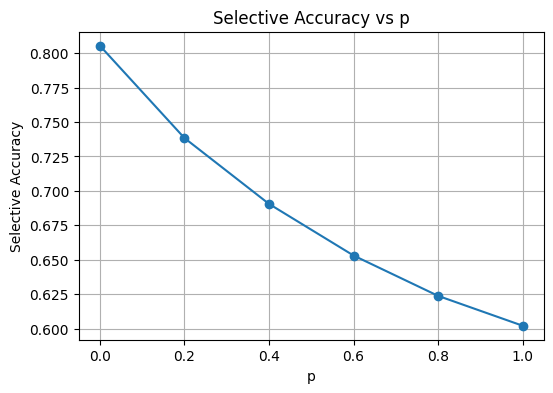

In [6]:
import torch, torch.nn as nn, torch.nn.functional as F

# Paper-consistent MNIST CNN (3x3 convs, bias=True). Pools arranged for 28->14->7->3 before kappa.
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1, bias=True)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, bias=True)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, bias=True)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1, bias=True)  # φ ends here
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1, bias=True)  # θ starts here
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256*3*3, 1024, bias=True)
        self.fc2 = nn.Linear(1024, 512, bias=True)
        self.fc3 = nn.Linear(512, num_classes, bias=True)

    def phi_forward(self, x):
        x = F.relu(self.conv1(x)); x = self.pool(x)   # 28->14
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x)); x = self.pool(x)   # 14->7
        x = F.relu(self.conv4(x)); x = self.pool(x)   # 7->3
        return x

m = CNN()
# Count φ params (conv1..conv4)
phi_params = sum(p.numel() for n,p in m.named_parameters() if n.startswith(("conv1","conv2","conv3","conv4")))
# Count θ params (conv5 + fc1 + fc2 + fc3)
theta_params = sum(p.numel() for n,p in m.named_parameters() if n.startswith(("conv5","fc1","fc2","fc3")))
# Kappa params (Linear(256*3*3 -> 10))
kappa = nn.Linear(256*3*3, 10, bias=True)
kappa_params = sum(p.numel() for p in kappa.parameters())

print("phi:", phi_params)      # 387840
print("theta:", theta_params)  # 3480330
print("kappa:", kappa_params)  # 23050


phi: 387840
theta: 3480330
kappa: 23050
